In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

In [ ]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]

n_chans, n_dipoles = leadfield.shape

# Simulate

In [ ]:
settings = dict(
    number_of_sources=3,
    extents=(1, 2),
    duration_of_trial=0.2,
    amplitudes=100,
    target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

In [46]:
from copy import deepcopy
G = deepcopy(leadfield)
G /= np.linalg.norm(G, axis=0)
# G = (G.T / np.linalg.norm(G, axis=1)).T
G = G.T @ G
G = np.linalg.norm(G, axis=0)
stc_.data[:, 0] = G
brain = stc_.plot(**pp)

brain.add_text(0.1, 0.9, "similarity", 'title',
               font_size=14)


Using control points [2.29915669 2.35301337 2.70258327]
Using control points [20.02893799 20.24380708 20.69146389]


No projector specified for this dataset. Please consider the method self.add_proj.


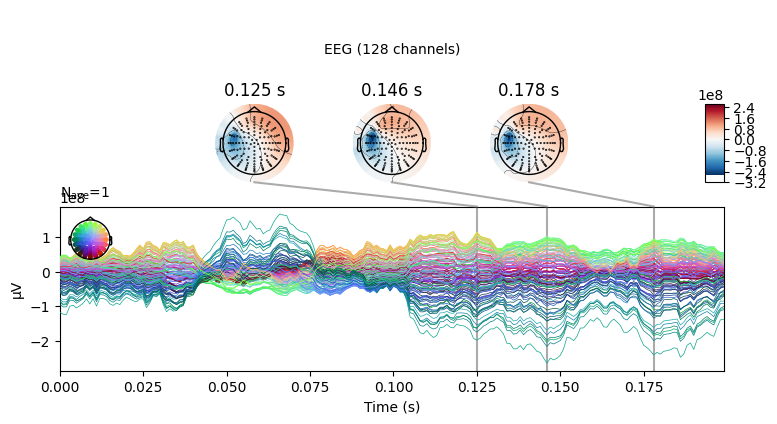

Using control points [0.        0.        0.2330672]


In [40]:
from invert import Solver
solver = Solver("champagne")
solver.make_inverse_operator(fwd, evoked, alpha=0.01)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

In [ ]:
from invert.adapters import stampc
stc_stamp = stampc(stc_, evoked, fwd, n_orders=2, rv_thresh=0.1)
stc_stamp.data /= abs(stc_stamp.data).max()
brain = stc_stamp.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_stamp.data, info)
evoked_.plot_joint()

# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl


all_solvers = [ "MNE", "wMNE", "dSPM", #"FISTA", "L1L2",
                "LORETA", "sLORETA", "eLORETA", 
                "LAURA", #"Backus-Gilbert", 
                "S-MAP",
                "Multiple Sparse Priors", "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", "Bayesian Beamformer LORETA", "Champagne", 
                "MVAB",
                "Fully-Connected", 
                #"LUCAS",
                "OMP", "COSAMP", "SOMP", "SP", "SSP", #"REMBO",
                "SMP", "SSMP", "SubSMP",
                "BCS", "Gamma-MAP", "Source-MAP"
            ]

redo_solvers = np.array(["Champagne", "Multiple Sparse Priors", 
            "Bayesian LORETA", "Bayesian MNE", "Bayesian Beamformer", 
            "Bayesian Beamformer LORETA", "Gamma-MAP", "Source-MAP"])

settings = dict(
    number_of_sources=(1, 8), 
    extents=(1, 35), 
    duration_of_trial=0.005, 
    target_snr=(2, 50))
alpha = "auto"

errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}
errors_nmse = {sname: [] for sname in all_solvers}

solvers = dict()
sim = Simulation(fwd, info, settings).simulate(25)
    
for i in range(sim.n_samples):
    print(i)
    stc = sim.source_data[i]
    evoked = sim.eeg_data[i].average()

    for solver_name in all_solvers :
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers) or solver_name in redo_solvers:
            if solver_name == "Fully-Connected":
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha, settings=dict(duration_of_trial=0., target_snr=(2,50), extents=(1, 35)), n_simulations=10000)
            else:
                solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha=alpha)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        try:
            stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
            error_corr = np.mean(corr(stc.data, stc_hat.data))

            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat.data))

        except:
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        errors_nmse[solver_name].append( error_nmse )
        if not solver_name + "_stampc" in errors_corr.keys():
            print("recreating")
            errors_corr[solver_name + "_stampc"] = []
            errors_mle[solver_name + "_stampc"] = []
            errors_auc[solver_name + "_stampc"] = []
            errors_nmse[solver_name + "_stampc"] = []
        try:
            stc_hat_stamp = stampc(stc_hat, evoked, fwd, n_orders=1, rv_thresh=0.1)

            error_corr = np.mean(corr(stc.data, stc_hat_stamp.data))
            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat_stamp.data[:, 0], pos)
            error_auc = eval_auc(stc.data[:, 0], stc_hat_stamp.data[:, 0], pos)
            error_nmse = np.median(nmse(stc.data, stc_hat_stamp.data))
        except:
            error_mle = np.nan
            error_auc = np.nan
            error_corr = np.nan
            error_nmse = np.nan
        errors_corr[solver_name + "_stampc"].append( error_corr )
        errors_mle[solver_name + "_stampc"].append( error_mle )
        errors_auc[solver_name + "_stampc"].append( error_auc )
        errors_nmse[solver_name + "_stampc"].append( error_nmse )
        
        # print(error_corr, error_mle, error_auc)

    print("Saving errors")
    fn = "errors.pkl"
    with open(fn, 'wb') as f:
        pkl.dump([errors_corr, errors_mle, errors_auc, errors_nmse, sim.simulation_info], f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors_corr, errors_mle, errors_auc = pkl.load(f)

In [ ]:
for key, val in errors_mle.items():
    errors_mle[key] = val[:31]

for key, val in errors_corr.items():
    errors_mle[key] = val[:31]

for key, val in errors_auc.items():
    errors_mle[key] = val[:31]
    

# Plot

In [ ]:
# df = pd.DataFrame(errors_nmse)
# df

for key, value in errors_nmse.items():
    errors_nmse[key] = [np.mean(l) for l in value]

In [ ]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)

# df = pd.DataFrame(errors_corr)
# df = pd.DataFrame(errors_mle)
df = pd.DataFrame(errors_auc)
# df = pd.DataFrame(errors_nmse)

sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
df_mean_var = df_mean_var.sort_values(by="Median")
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)